In [2]:
from dataset import PretrainingDataset,SegmentationDataset,LungCTFullImageDataset,LungRadiomicsInterobserverDataset,LungRadiomicsDataset,VolumeLungRadiomicsInterobserverDataset,VolumeLungRadiomicsDataset
from model import ThreeDimensionalTransformer,load_model
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from pretrain import make_data
import pydicom
from train import make_data,make_model,train
from metrics import DSC,DSCManager
from loss_function import DiceLoss,DSLManager


In [3]:
model=load_model("/home/nfs/snakagawa/Strage/CancerSegmentation/models/train/2022-01-18-17-56-9.pt",torch.device("cpu"),"VolumeTransformer")

In [4]:
dataset=VolumeLungRadiomicsDataset()

423it [00:01, 354.88it/s]


In [67]:
patch_provider=dataset[0]

In [5]:
loader=DataLoader(dataset,batch_size=1)

In [6]:
image,labels =next(iter(loader))

In [7]:
label=list(labels.values())[0]

In [71]:
model=model.to(torch.device("cuda:0"))
image=image.to(torch.device("cuda:0"))

In [40]:
for image,labels in loader:
    label=list(labels.values())[0]
    if label[0,0].max()>0:
        break


In [8]:
#image=image.to(torch.device("cuda:0"))
predict=model(image).cpu().detach()
image=image.cpu().detach()

In [47]:
for depth in range(8):
    if label[0,0,depth].max()!=0:
        print(depth)

5


In [9]:
predict.size()


torch.Size([1, 2, 320, 512, 512])

In [48]:
predict[0,0,5].max()

tensor(0.0195)

In [42]:
predict.size()

torch.Size([1, 2, 8, 8, 8])

In [38]:
image.size()

torch.Size([1, 1, 24, 24, 24])

In [56]:
label[:,0].view(-1).size()

torch.Size([512])

In [75]:
predict

tensor([[[[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000

In [77]:
predict.size()

torch.Size([1, 2, 320, 512, 512])

In [18]:
predict[0,0,0,240:250,240:250]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [78]:
torch.where(predict[0,0,depth]>0.5,1,0)

tensor([[0, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

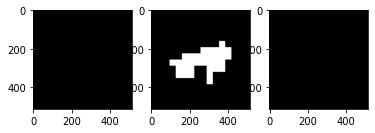

In [14]:
depth=220
fig,axs=plt.subplots(1,3)
axs[0].imshow(image[0,0,depth],cmap="gray")
axs[1].imshow(predict[0,0,depth],cmap="gray")
axs[2].imshow(label[0,0,depth],cmap="gray")
fig.show()

In [80]:
DiceLoss(predict,labels)

tensor(0.9987)

In [79]:
DSC(torch.where(predict>0.5,1,0),labels)


tensor(0.0005)

In [5]:
i=0
cancers=[]
for image,labels in loader:    
    max=list(labels.values())[0][0,0].max()
    if max>0:
        cancers.append((image,labels))
        #print(i)
        i+=1
print(i)


81


In [6]:
image=patch_provider.cube
label=list(patch_provider.labels.values())[0]
for i in range(image.size()[0]):
    if label[i].max()!=0:
        print(i)

23
24
25
26
27
28
29
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


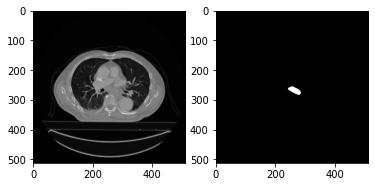

In [7]:
depth=33
fig,axs=plt.subplots(1,2)
axs[0].imshow(image[depth],cmap="gray")
axs[1].imshow(label[depth],cmap="gray")
fig.show()

In [24]:
cancer_id=50
for depth in range(8):
    label=list(cancers[cancer_id][1].values())[0]
    if label[0,0,depth].max()!=0:
        print(depth)

1
2
3
4
6


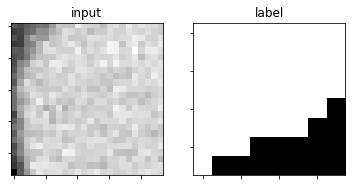

In [27]:
depth=3
fig,axs=plt.subplots(1,2)
axs[0].imshow(cancers[cancer_id][0][0,0,depth+8],cmap="gray")
axs[1].imshow(list(cancers[cancer_id][1].values())[0][0,0,depth],cmap="gray")
fig.show()
axs[0].set_title("input")
axs[1].set_title("label")
axs[0].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)
axs[1].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)

In [13]:
len(axs)

2

In [21]:
patch_provider.cube.size()

torch.Size([184, 512, 512])

In [8]:
label=list(labels.values())[0]

In [9]:
for i in range(8):
    if label[0,0,i].max()!=0:
        print(i)

4
5
6
7


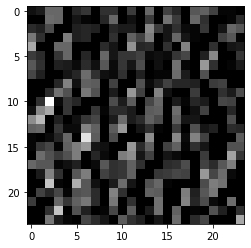

In [18]:
plt.imshow(image[0,0,13],cmap ="gray")

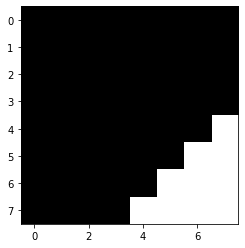

In [13]:
plt.imshow(label[0,0,4,:,:],cmap="gray")


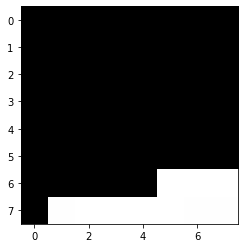

In [17]:
plt.imshow(labels["label"][0,0,0,:,:],cmap="gray")


In [30]:
pre=model(image)


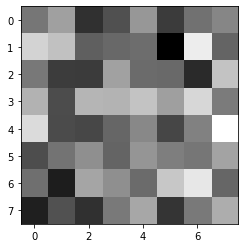

In [31]:
plt.imshow(pre.detach().numpy()[0,0,0,:,:],cmap="gray")

In [32]:
DiceLoss(pre,labels)

tensor(0.9961, grad_fn=<MeanBackward0>)

In [2]:
traindata,valdata=make_data()
model=make_model()

23it [00:31,  1.36s/it]

make_data function took 0[h] 0[min] 7[s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [11]:
BATCH_SIZE=5
patch_provider=traindata[0]
trainloader=DataLoader(patch_provider,batch_size=BATCH_SIZE)
dscmanager=DSCManager()
for image,labels in trainloader:
    pre=torch.zeros_like(list(labels.values())[0])
    dscmanager.register(pre,labels)
dsc=dscmanager.calculate()
print(dsc)

tensor(1.4327e-05)


In [4]:
for image,label in trainloader:
    if label['GTV-1auto-3'][4][0].max()!=0:
        print("end")
        break 
    

end


In [34]:
image[:,:,16:32,16:32,16:32].size()

torch.Size([5, 2, 16, 16, 16])

In [5]:
label['GTV-1auto-3'][4][0][10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1

In [10]:
label.keys()

dict_keys(['GTV-1auto-3', 'GTV-1vis-1', 'GTV-1vis-4', 'GTV-1vis-5', 'GTV-1auto-2', 'GTV-1vis-3', 'GTV-1auto-4', 'GTV-1vis-2', 'GTV-1auto-5', 'GTV-1auto-1'])

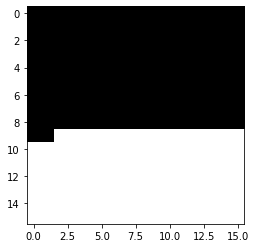

In [13]:
plt.imshow(label['GTV-1vis-'][4][0][10],cmap="gray")

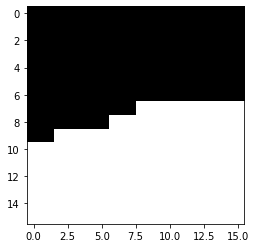

In [6]:
plt.imshow(label['GTV-1auto-3'][4][0][10],cmap="gray")

In [15]:
image.size()

torch.Size([5, 2, 48, 48, 48])

In [17]:
pre=model(image.to(torch.device("cuda:0")))

In [32]:
pre.size()

torch.Size([5, 2, 16, 16, 16])

In [36]:
DSC(pre,[image[:,:,16:32,16:32,16:32].to(torch.device("cuda:0"))])

tensor(0.8086, device='cuda:0', grad_fn=<DivBackward0>)

In [46]:
#DSC(pre.cpu(),label)
DiceLoss(pre.cpu(),label)

tensor(0.1078, grad_fn=<DivBackward0>)

In [47]:
DSC(pre.cpu(),label)

TypeError: flatten(): argument 'input' (position 1) must be Tensor, not str

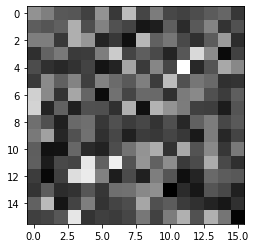

In [22]:
plt.imshow(pre[4][0][10].cpu().detach().numpy(),cmap="gray")

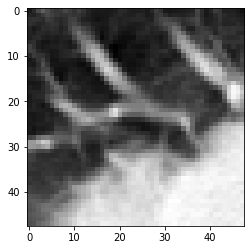

In [7]:
plt.imshow(image[4][0][26],cmap="gray")

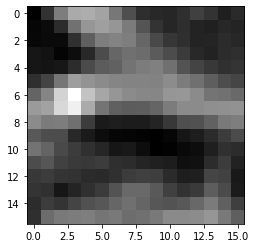

In [26]:
plt.imshow(image[4][0][26][16:32,16:32],cmap="gray")

In [3]:
dataset=LungRadiomicsInterobserverDataset()

abstract method


13it [01:44,  8.92s/it]

shape (1780, 512, 512) (890, 512, 512)


23it [03:18,  8.65s/it]


In [4]:
#dataloader=DataLoader(dataset,batch_size=1,collate_fn=collate_fn)
dataloader=DataLoader(dataset[0],batch_size=1)

In [7]:
next(iter(dataloader))[0].size()

torch.Size([1, 2, 48, 48, 48])

In [ ]:
with pydicom.dcmread("/home/s0ran/Strage/CancerSegmentation/dataset/manifest-1598890146597/NSCLC-Radiomics-Interobserver1/interobs05/02-18-2019-NA-CT-90318/1.000000-Segmentation-94745/1-1.dcm") as dc:
    print(dir(dc))
    print(dc.SeriesDescription)

In [ ]:
train,test=make_data()

In [ ]:
for i in range(2000):
    print(i,train[0][1][i][0][0].max())

In [ ]:
dataset=LungCTFullImageDataset()
patch_provider=train[0][1]
print(patch_provider[0][0][0].size())
print(patch_provider[0][0][0].argmax())
plt.imshow(patch_provider[7][0][0][20],cmap="gray")

In [ ]:
image_id=0
patch_id=50
dataset=train[image_id][1]
depth_id=0
fig,axs=plt.subplots(1,2)
axs[0].imshow(dataset[patch_id][0][0][depth_id+16],cmap="gray",vmin=0,vmax=1)
axs[0].set_title("input")
axs[1].imshow(dataset[patch_id][1][0][depth_id],cmap="gray",vmin=0,vmax=1)
axs[1].set_title("ground truth")
print(dataset[patch_id][0][0][depth_id+16].min())
print(dataset[patch_id][0][0][depth_id+16].max())
print(dataset[patch_id][1][0][depth_id].min())
print(dataset[patch_id][1][0][depth_id].max())


for ax in axs:
    pass
    ax.axis("off")

fig.savefig("../images/pretrainingexample2")

In [ ]:
for pathc_id in range(len(dataset)):
    print(dataset[patch_id][0][0][depth_id].sum())


In [ ]:
dataset[0][1].shape

In [ ]:
dataset[0][1].sum(dim=1).sum(dim=1).size()


In [ ]:
image_id=0
depth_id=45

fig,axs=plt.subplots(1,2)
axs[0].imshow(dataset[image_id][0][depth_id],cmap="gray")
axs[0].set_title("raw image")
axs[1].imshow(dataset[image_id][1][depth_id*10],cmap="gray")
axs[1].set_title("segmentation")
for ax in axs:
    ax.axis("off")
fig.savefig("../images/tumorexample.png")

In [ ]:
image_id=0
#depth_id=45
start=446
end=458
sep=4

fig,axs=plt.subplots((end-start)//sep,sep)
for i,v in enumerate(range(446,458)):
    axs[i//sep][i%sep].imshow(dataset[image_id][1][v],cmap="gray")
    axs[i//sep][i%sep].set_title(v)
    axs[i//sep][i%sep].axis("off")
fig.savefig("../images/surrounding.png")

In [ ]:
data,label=pretraining_data[0][1][900]
label.size()
plt.imshow(label[0],cmap="gray")

In [ ]:
metadata.columns
features=['Series UID', 
       #'Collection',
       # '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 
       #'SOP Class UID', 
       'Number of Images', 'File Size',
       'File Location', 'Download Timestamp']

In [ ]:
metadata["SOP Class Name"].unique()

In [ ]:
metadata[metadata["Subject ID"]=="Lung_Dx-A0166"]

In [ ]:
len(metadata[metadata["Modality"]=="PT"])

In [ ]:
metadata[metadata["Study UID"]=="1.3.6.1.4.1.14519.5.2.1.6655.2359.104855313699639828167809534834"]